<a href="https://colab.research.google.com/github/ghuioio/project3/blob/main/mae_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
pip install yfinance

In [118]:
import numpy as np
np.random.seed(1) # for reproducibility
import keras
import keras.backend as K
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import yfinance as yf
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [119]:
'''Step 1 - Download stock price data from yahoo finance'''
hsbc = yf.download('0005.HK', '2000-01-01', '2021-01-01')
hsbc = hsbc.drop(['Adj Close'], axis=1)
hsbc = hsbc.drop(hsbc[hsbc.Volume==0].index)
print(hsbc.head())

[*********************100%***********************]  1 of 1 completed
             Open   High     Low  Close    Volume
Date                                             
2000-01-03  111.0  111.5  107.50  108.0   3908164
2000-01-04  106.0  106.5  105.00  106.0   6895378
2000-01-05  101.0  102.0   99.50  100.5  14657098
2000-01-06  101.0  102.0   96.25   97.0  10632084
2000-01-07   98.5  101.0   97.50  100.5   8368286


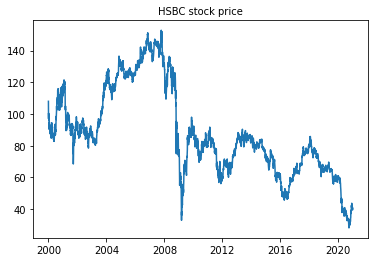

In [120]:
'''Step 2 - Plot stock price & volume'''
fig, ax1 = plt.subplots()
ax1.set_title('HSBC stock price', fontsize=10)
ax1.plot(hsbc['Close'])
plt.show()

In [121]:
'''Step 3 - Split data into training set and test set'''
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(hsbc, train_size=0.8, test_size=0.2, shuffle=False)
print("Training data set size -", len(df_train))
print("Test data set size -", len(df_test))

Training data set size - 4134
Test data set size - 1034


In [122]:
'''Step 4 - Scale feature MinMax  - Train the scaler with training data and smooth data'''
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [123]:
'''Step 5 - Set environment parameters'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [124]:
'''Step 6 - Set model parameters'''
#set parameters for model
params = {
    "BATCH_SIZE": 64,
    "EPOCHS": 50,
    "LR": 0.00010000,
    "TIME_STEPS": 60
    }
TIME_STEPS = params['TIME_STEPS']
BATCH_SIZE = params['BATCH_SIZE']
stime = time.time()

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ", np.round(seconds%60),"seconds")

In [125]:
'''Step 7 - Filtering datasets for training model'''

def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [126]:
'''Step 8 - Transform data into time series format'''

def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size", x_t.shape, y_t.shape)

Length of inputs 4074
length of time-series - inputs (4074, 60, 5)
length of time-series - outputs (4074,)
Batch trimmed size (4032, 60, 5) (4032,)


In [127]:
'''Step 10 - Build LSTM model'''

model_lstm = Sequential()
model_lstm.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                    dropout=0.4, recurrent_dropout=0.0,
                    stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
model_lstm.add(LSTM(60, dropout=0.4))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='mae', optimizer= tf.optimizers.Adam(lr=params["LR"]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [128]:
'''Step 11 - Split test data into validation set and test set'''
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.array_split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.array_split(trim_dataset(y_temp, BATCH_SIZE), 2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Length of inputs 974
length of time-series - inputs (974, 60, 5)
length of time-series - outputs (974,)
Test size (480, 60, 5) (480,) (480, 60, 5) (480,)


In [129]:
'''Step 12 - Train the model '''
history_lstm = model_lstm.fit(x_t, y_t, epochs=params["EPOCHS"], verbose=1, batch_size=BATCH_SIZE,
                      shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE)),)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
63/63 [==============================] - 20s 323ms/step - loss: 0.1905 - val_loss: 0.1711
Epoch 2/50
63/63 [==============================] - 20s 322ms/step - loss: 0.1862 - val_loss: 0.1700
Epoch 3/50
63/63 [==============================] - 20s 326ms/step - loss: 0.1830 - val_loss: 0.1641
Epoch 4/50
63/63 [==============================] - 20s 324ms/step - loss: 0.1804 - val_loss: 0.1555
Epoch 5/50
63/63 [==============================] - 20s 323ms/step - loss: 0.1741 - val_loss: 0.1290
Epoch 6/50
63/63 [==============================] - 20s 324ms/step - loss: 0.1618 - val_loss: 0.0847
Epoch 7/50
63/63 [==============================] - 20s 323ms/step - loss: 0.1229 - val_loss: 0.0347
Epoch 8/50
63/63 [==============================] - 21s 331ms/step - loss: 0.1030 - val_loss: 0.0343
Epoch 9/50
63/63 [==============================] - 20s 324ms/step - loss: 0.0674 - val_loss: 0.0363
Epoch 10/50
63/63 [==============================] - 21s 327ms/step - loss: 0.0487 - val_lo

In [130]:
''' Step 13 - predict the model on test data'''
y_pred_lstm = model_lstm.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_lstm = y_pred_lstm.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error_lstm = mean_squared_error(y_test_t, y_pred_lstm)
print("Error is", error_lstm, y_pred_lstm.shape, y_test_t.shape)
print(y_pred_lstm[0:15])
print(y_test_t[0:15])

y_pred_lstm_org = (y_pred_lstm * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error is 0.0019909997356171846 (448,) (448,)
[0.25431702 0.2544206  0.25470883 0.25474387 0.2547317  0.25471252
 0.25477847 0.2549724  0.25497943 0.25486425 0.25492722 0.255032
 0.25511035 0.25528282 0.25554153]
[0.25667779 0.26544242 0.25292152 0.25250417 0.26168612 0.26627713
 0.26502503 0.27128547 0.26544242 0.27045076 0.26335561 0.26794656
 0.26836395 0.26836395 0.27003337]
[63.46718  63.47959  63.51412  63.51832  63.51686  63.51456  63.52246
 63.545692 63.54654  63.532738 63.540283 63.552834 63.56222  63.582882
 63.613876]
[63.75       64.80000305 63.29999924 63.25       64.34999847 64.90000153
 64.75       65.5        64.80000305 65.40000153 64.55000305 65.09999847
 65.15000153 65.15000153 65.34999847]


Error is 0.5011185682326622


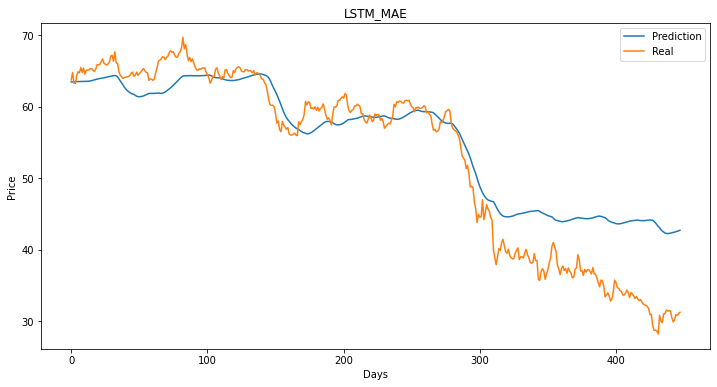

In [131]:
'''Step 16 - Plot real stock price & prediction'''
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(y_pred_lstm_org)
plt.plot(y_test_t_org)
plt.title('LSTM_MAE')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred_lstm)-1,))

for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0

error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
print("Error is", error_lstm)

In [132]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(60,5)))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='mae', optimizer='adam')

In [133]:
history_cnn = model_cnn.fit(x_t, y_t, epochs=params["EPOCHS"], verbose=1, batch_size=BATCH_SIZE,
                      shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE)),)

Epoch 1/50
 3/63 [>.............................] - ETA: 2s - loss: 0.1921

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 3s 45ms/step - loss: 0.1926 - val_loss: 0.1344
Epoch 2/50
63/63 [==============================] - 3s 43ms/step - loss: 0.2542 - val_loss: 0.0618
Epoch 3/50
63/63 [==============================] - 3s 43ms/step - loss: 0.1826 - val_loss: 0.0496
Epoch 4/50
63/63 [==============================] - 3s 41ms/step - loss: 0.1851 - val_loss: 0.0778
Epoch 5/50
63/63 [==============================] - 3s 41ms/step - loss: 0.1928 - val_loss: 0.2207
Epoch 6/50
63/63 [==============================] - 3s 41ms/step - loss: 0.2665 - val_loss: 0.1906
Epoch 7/50
63/63 [==============================] - 3s 42ms/step - loss: 0.2767 - val_loss: 0.0652
Epoch 8/50
63/63 [==============================] - 3s 42ms/step - loss: 0.1021 - val_loss: 0.1238
Epoch 9/50
63/63 [==============================] - 3s 42ms/step - loss: 0.1643 - val_loss: 0.0508
Epoch 10/50
63/63 [==============================] - 3s 43ms/step - loss: 0.1403 - val_loss: 0.0355
Epoch 11/50
63/63 [=

In [134]:
y_pred_cnn = model_cnn.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_cnn = y_pred_cnn.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error_cnn = mean_squared_error(y_test_t, y_pred_cnn)
print("Error is", error_cnn)
print(y_pred_cnn[0:15])
print(y_test_t[0:15])

y_pred_cnn_org = (y_pred_cnn * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_cnn_org[0:15])
print(y_test_t_org[0:15])

Error is 0.002706769536261979
[0.30050176 0.30191612 0.3026464  0.30244637 0.3022907  0.30144656
 0.30123514 0.30077016 0.30054653 0.2986919  0.2972221  0.29593566
 0.2957086  0.2957725  0.29638353]
[0.25667779 0.26544242 0.25292152 0.25250417 0.26168612 0.26627713
 0.26502503 0.27128547 0.26544242 0.27045076 0.26335561 0.26794656
 0.26836395 0.26836395 0.27003337]
[69.00011  69.169556 69.257034 69.23308  69.21443  69.1133   69.08797
 69.032265 69.00548  68.783295 68.60721  68.453094 68.42589  68.43355
 68.506744]
[63.75       64.80000305 63.29999924 63.25       64.34999847 64.90000153
 64.75       65.5        64.80000305 65.40000153 64.55000305 65.09999847
 65.15000153 65.15000153 65.34999847]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error is 0.49440715883668906 (447,) (447,)
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]


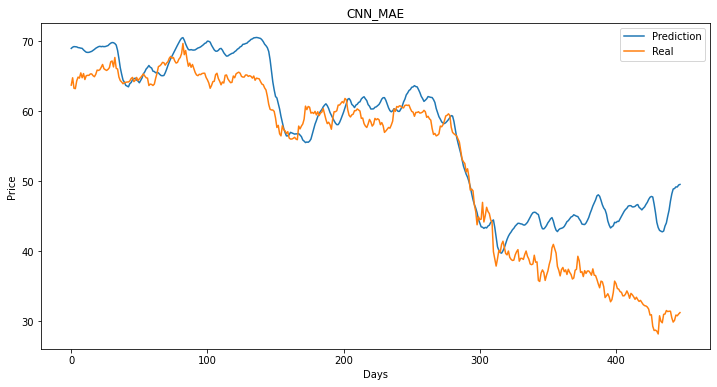

In [135]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(y_pred_cnn_org)
plt.plot(y_test_t_org)
plt.title('CNN_MAE')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_cnn_final = np.zeros((len(y_pred_cnn)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_cnn_org)-1):
    if y_pred_cnn_org[i+1] >= y_pred_cnn_org[i]:
        y_pred_cnn_final[i] = 1
    else:
        y_pred_cnn_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


error_cnn = mean_absolute_error(y_test_t_final, y_pred_cnn_final)
print("Error is", error_cnn, y_pred_cnn_final.shape, y_test_t_final.shape)
print(y_pred_cnn_final[0:15])
print(y_test_t_final[0:15])

In [136]:
(len(y_test_t_org))

448